In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import itertools

from utils.plot_config import *
mpl.rc('lines', linewidth=plot_line_width)

In [2]:
ranks_path = "data/results/sampling_results"
methods = ["full", "0.1", "100", "0.001"]
model_a = "coveo_optuna_mrr_bprmax_constrained_fulltrain"
model_b = "coveo_optuna_mrr_xe_constrained_fulltrain"
models = {"Model A": model_a, "Model B": model_b,}

In [3]:
def load_data(file_name):
    data = pd.read_csv(file_name, sep='\t', header=None)
    data = data.values.flatten()
    return data

def format_plot(ax, handles, legend_loc="best"):
    ax.legend(handles=handles, loc=legend_loc, prop={'size': fontsize*0.8})
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(plot_axis_line_width)
    # increase tick width
    ax.tick_params(width=plot_axis_line_width)
    ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
    ax.xaxis.grid()

# intersection between line(p1, p2) and line(p3, p4)
def intersect(p1, p2, p3, p4):
    x1,y1 = p1[:,0], p1[:,1]
    x2,y2 = p2[:,0], p2[:,1]
    x3,y3 = p3[:,0], p3[:,1]
    x4,y4 = p4[:,0], p4[:,1]
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    xs = x1 + ua * (x2-x1)
    ys = y1 + ua * (y2-y1)
    return xs, ys

In [4]:
def create_plot(ranks_path, models, methods, metric="recall", show_intersection=True):
    fig, ax_main = plt.subplots(figsize=(15,10))
    plot_handles = []
    intersec_handles = []
    for i, method in enumerate(methods):
        metric_values_for_method = []
        for j, (model_name_key, model_name_val) in enumerate(models.items()):
            metric_values = load_data(os.path.join(ranks_path, f"{model_name_val}_{method}_{metric}.tsv"))
            metric_values_for_method.append(metric_values)
            color = colors[f"color_{j%3}"]
            linestyle = linestyles[i%len(linestyles)]
            plot_handle, = ax_main.plot(np.arange(len(metric_values))+1, metric_values, label=f"{model_name_key} ({method})", linestyle=linestyle, c=color)
            plot_handles.append(plot_handle)
        if show_intersection:
            for val1, val2 in itertools.permutations(metric_values_for_method):
                signs = np.sign(val1-val2)
                signs_mask = np.diff(signs).astype(bool)
                idx_intersect = np.argwhere(signs_mask).flatten()
                if len(idx_intersect) > 0:
                    xs = np.arange(len(val1))+1
                    p1s = np.hstack((xs[idx_intersect].reshape(-1,1), val1[idx_intersect].reshape(-1,1)))
                    p2s = np.hstack((xs[idx_intersect+1].reshape(-1,1), val1[idx_intersect+1].reshape(-1,1)))
                    p3s = np.hstack((xs[idx_intersect].reshape(-1,1), val2[idx_intersect].reshape(-1,1)))
                    p4s = np.hstack((xs[idx_intersect+1].reshape(-1,1), val2[idx_intersect+1].reshape(-1,1)))
                    x_int, y_int = intersect(p1s,p2s,p3s,p4s)
                    intersec_handle, = ax_main.plot(x_int, y_int, 'ro', markersize=12, label="intersection", markeredgecolor="black") #ro
                    intersec_handles.append(intersec_handle)

    if len(intersec_handles) > 0:
        plot_handles.append(intersec_handles[-1])
    legend_loc = "best"
    format_plot(ax=ax_main, legend_loc=legend_loc, handles=plot_handles) #"best"
    ax_main.set_xlabel("N", fontsize=fontsize)
    ax_main.set_ylabel(metric, fontsize=fontsize)
    ax_main.set_xscale('log')
    plt.show()
        

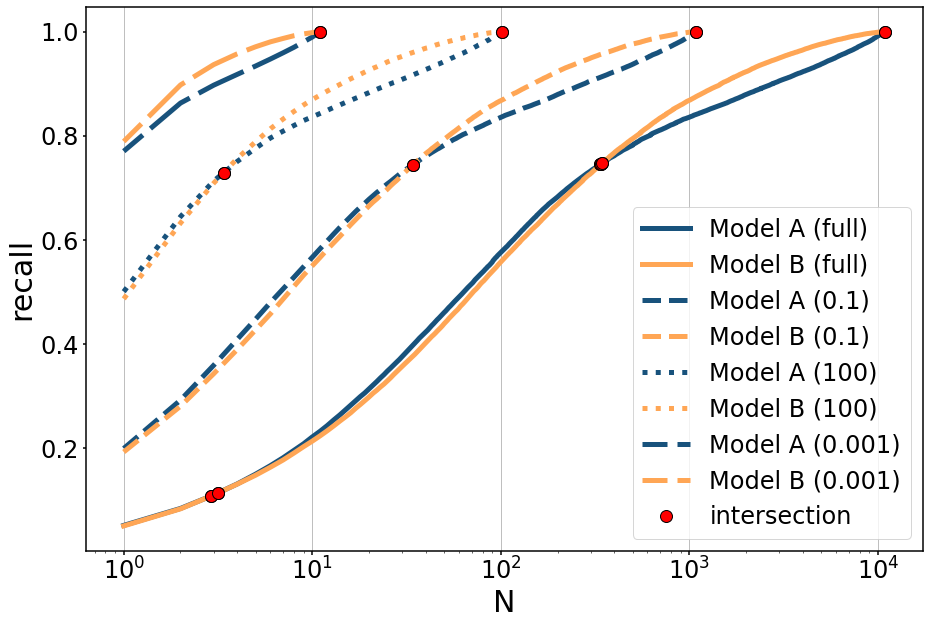

In [5]:
create_plot(ranks_path=ranks_path, models=models, methods=methods, metric="recall", show_intersection=True)

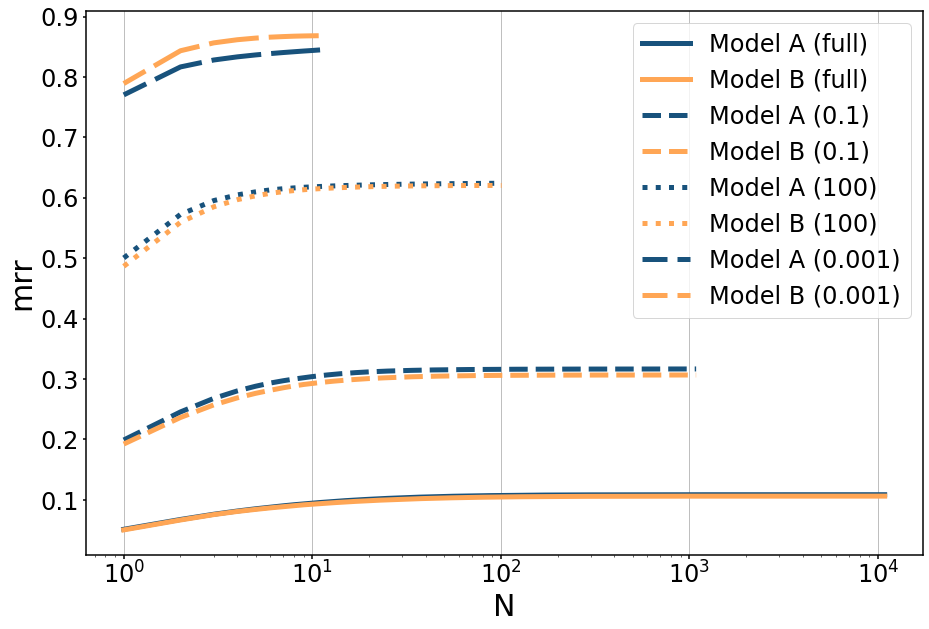

In [6]:
create_plot(ranks_path=ranks_path, models=models, methods=methods, metric="mrr", show_intersection=True)